In [1]:
%pylab
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform, cdist

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import wfg

In [3]:
figsize(8,8)

In [4]:
def notDominated(X):
    """
    Return a Boolean vector with as many rows as X indicating whether each
    row of X is not dominated by the other elements of X; ie, whether each
    row is Pareto optimal for X.
    """
    y = zeros(X.shape[0], dtype='bool')
    for n in range(X.shape[0]):
        # Find the number of times on each row where X[i,j] >= X[n,j];
        # y[n] is not dominated if this is bigger than for every row
        y[n] = min(sum(X >= X[n,:], 1)) > 0
    return y

In [5]:
def weak_dominates(Y, x):
    """
    Test whether rows of Y weakly dominate x
    
    Parameters
    ----------
    Y : array_like
        Array of points to be tested. 
        
    x : array_like
        Vector to be tested
        
    Returns
    -------
    c : ndarray (Bool)
        1d-array.  The ith element is True if Y[i] weakly dominates x
    """
    return (Y <= x ).sum(axis=1) == Y.shape[1]


def attainment_sample(Y, Nsamples=1000):
    """
    Return samples from the attainment surface defined by the mutually non-dominating set Y

    Parameters
    ---------
    Y : array_like
        The surface to be sampled. Each row of Y is vector, that is mutually
        with all the other rows of Y
    Nsamples : int
        Number of samples

    Returns
    -------
    S : ndarray
        Array of samples from the attainment surface.
        Shape; Nsamples by Y.shape[1] 
    
    Notes
    -----
    See "Dominance-based multi-objective simulated annealing"
    Kevin Smith, Richard Everson, Jonathan Fieldsend, 
    Chris Murphy, Rashmi Misra.
    IEEE Transactions on Evolutionary Computing. 
    Volume: 12, Issue: 3, June 2008.
    https://ieeexplore.ieee.org/abstract/document/4358782
    """
    N, D = Y.shape
    Ymin = Y.min(axis=0)
    r = Y.max(axis=0) - Ymin
    S = np.zeros((Nsamples, D))
    
    # Set up arrays of the points sorted according to each coordinate.
    Ys = np.zeros((N, D))
    for d in range(D):
        Ys[:,d] = np.sort(Y[:,d])

    for n in range(Nsamples):
        v = np.random.rand(D)*r + Ymin
        m = np.random.randint(D)

        # Bisection search to find the smallest v[m] 
        # so that v is weakly dominated by an element of Y
        lo, hi = 0, N
        while lo < hi:
            mid = (lo+hi)//2
            v[m] = Ys[mid,m]
            if not any(weak_dominates(Y, v)):
                lo = mid+1
            else:
                hi = mid
        if lo == N: lo -= 1
        v[m] = Ys[lo, m]      
        assert lo == N-1 or any(weak_dominates(Y, v))
        S[n,:] = v[:]
    return S


### Sample from the attainment surface 

#### Example in 2D

In [6]:
N = 500
M = 2                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

f = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f[n,:] = func(z, k, M)


I = notDominated(f)
# f = f[I,:]
# f.shape



Text(0.5, 1.0, 'non-dominated points')

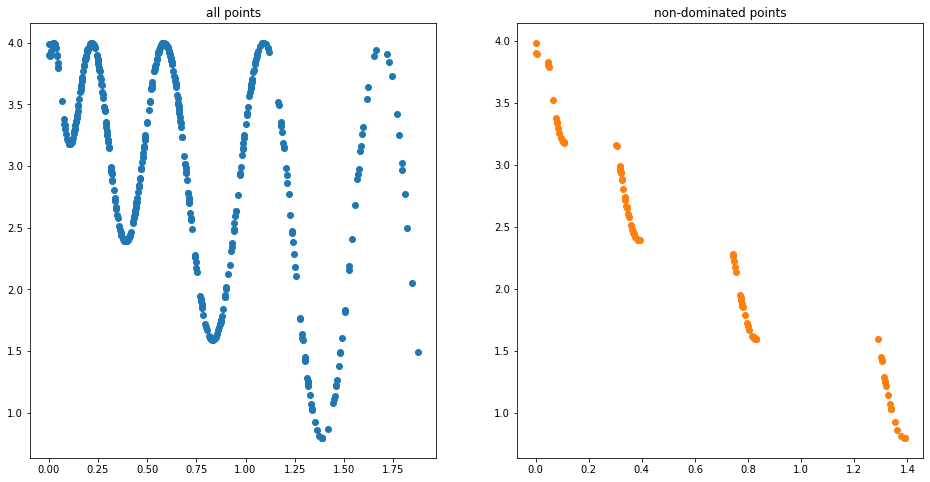

In [7]:
fig, axs = plt.subplots(1,2, figsize=[16, 8])
axs[0].scatter(*f.T, c="C0")
axs[1].scatter(*f[I].T, c="C1")

axs[0].set_title("all points")
axs[1].set_title("non-dominated points")

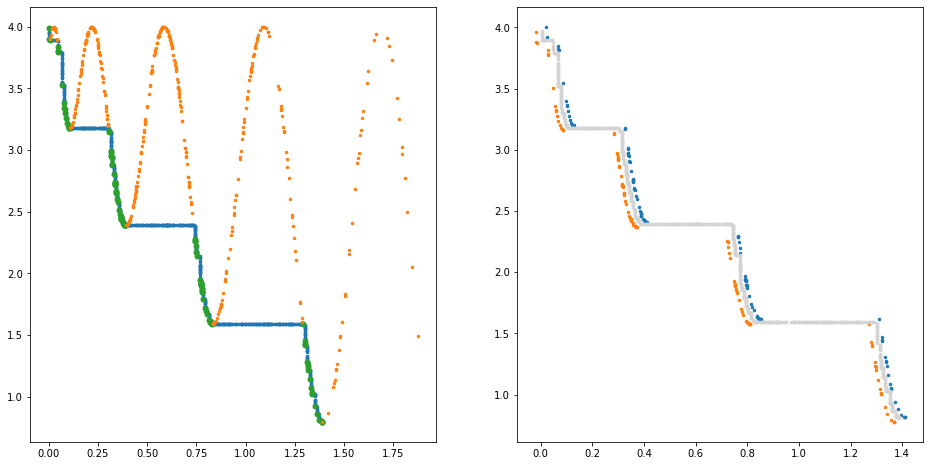

In [8]:
fig, axs = plt.subplots(1,2, figsize=[16, 8])
S = attainment_sample(f[I], 1000)
axs[0].plot(*S.T, '.', c="C0", ms=5)
axs[0].plot(*f[I].T, '.', c="C2", ms=10)
axs[0].plot(*f[np.invert(I)].T, '.', c="C1", ms=5)

eta = 0.02
f2 = f-eta
f3 = f+eta

axs[1].plot(*f3[I].T, '.', ms = 5)
axs[1].plot(*f2[I].T, '.', ms = 5)
axs[1].plot(*S.T, '.', ms = 5, c="lightgrey")


In [10]:
def f_wfg2(x):
    return np.product(np.sin((x*np.pi)/2), axis=1)
#     y1 = np.cos((x*np.pi)/2)
#     return np.hstack(y0, y1)

In [11]:
x = f_wfg2()
x

<module 'numpy' from '/home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/numpy/__init__.py'>

In [ ]:

a = find_dominators(f-eta[I], )

In [13]:
S.shape

(1000, 2)

In [9]:
def dominates(a: np.ndarray, b: np.ndarray, maximize: bool = False):
    """
    returns True if a dominates b, else returns False

    :param np.ndarray a: dominating query point
    :param np.ndarray b: dominated query points (n_points, point_dims)
    :param bool maximize: True for finding domination relation in a
    maximisation problem, False for minimisaiton problem.
    :return bool: True if a dominate b, else returns False"
    """
    if len(a) < 2:
        if maximize:
            return np.all(a > b)
        else:
            return np.all(a < b)
    else:
        # allows
        if maximize:
            return np.any(np.all(a > b))
        else:
            return np.any(np.all(a < b))


def find_dominators(dominators, dominatees):
    dom = np.zeros(dominators.shape[0])
    for i, A in enumerate(dominators):
        for j, B in enumerate(dominatees):
            if dominates(A, B):
                dom[i] = 1
    return np.array(dom, dtype=bool)

In [ ]:
# need point in S which dominate

In [39]:
SS = S.copy()
eta=0.1
d_inds = find_dominators(SS, f[I]-eta)

In [40]:
d_inds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

#### 3 dimensions

Text(0.5, 0.98, 'WFG2')

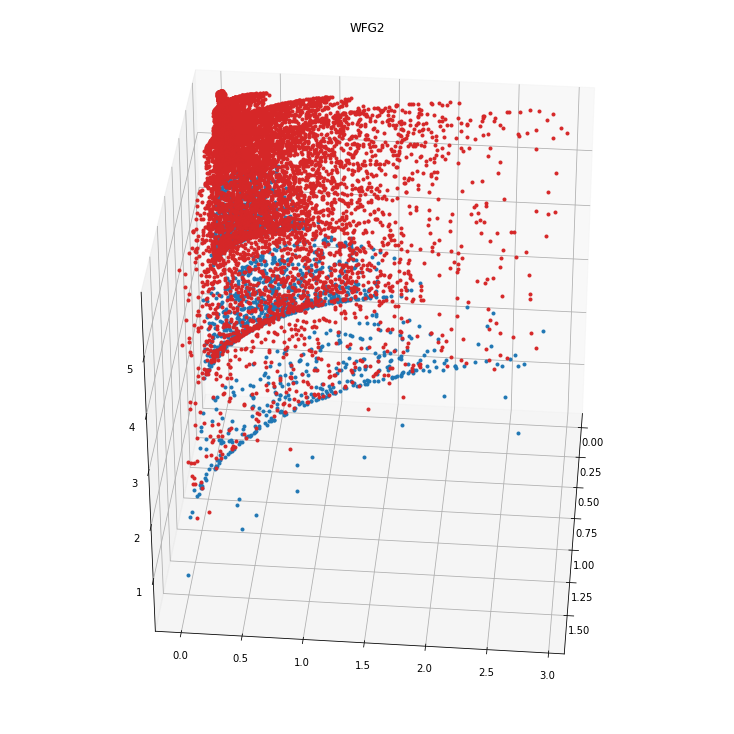

In [101]:
N = 10000
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

f3 = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f3[n,:] = func(z, k, M)


fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

I = notDominated(f3) 
D = np.invert(I)
f3_I = f3[I,:]
f3_D = f3[D,:]
f3.shape
plt.plot(*f3_I.T, '.', c="C0")
plt.plot(*f3_D.T, '.', c="C3")
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)


In [30]:
%matplotlib osx

In [12]:
S = attainment_sample(f3_I, 10000)
S.shape

(10000, 3)

In [21]:
comb = np.vstack((S, f3_D))
comb.shape

(17595, 3)

In [25]:
inds = np.invert(notDominated(comb))

In [29]:
aa = inds[:10000]
print(np.sum(aa))
print(len(aa))

0
10000


In [24]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot(*S.T, '.', ms=1)
ax.plot(*S2.T, '.', ms=1, c="C3")
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__ + ' attainment surface samples')

Text(0.5, 0.98, 'WFG2 attainment surface samples')

In [110]:
ans = find_dominators(comb)

In [111]:
print(np.sum(ans))
print(ans.shape)

1071.0
(1075,)


In [113]:
ans

array([1., 1., 1., ..., 1., 1., 1.])